# Part 1: Station Metadata

In [1]:
from cassandra.cluster import Cluster
try:
    cluster = Cluster(['project-5-bencoleman-db-1', 'project-5-bencoleman-db-2', 'project-5-bencoleman-db-3'])
    session = cluster.connect()
except Exception as e:
    print(e)

In [2]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS weather
    WITH replication = {'class':'SimpleStrategy', 'replication_factor':3}
""")

session.execute("""
    CREATE TYPE IF NOT EXISTS weather.station_record (
        tmin int,
        tmax int
    )
""")

session.execute("""
    CREATE TABLE IF NOT EXISTS weather.stations (
        id text,
        name text STATIC,
        date date,
        record frozen<station_record>,
        PRIMARY KEY (id, date)
    )
""")

### Q1: what is the schema?


In [3]:
print(session.execute("describe keyspace weather").one().create_statement)
print(session.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;
CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record frozen<station_record>,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair = 'BLOC

In [4]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0')
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7c26d844-28dd-4176-b680-72568751a998;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.gith

In [5]:
!wget 'https://pages.cs.wisc.edu/~harter/cs639/data/ghcnd-stations.txt'

--2023-04-13 21:30:53--  https://pages.cs.wisc.edu/~harter/cs639/data/ghcnd-stations.txt
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10607756 (10M) [text/plain]
Saving to: ‘ghcnd-stations.txt’

ghcnd-stations.txt  100%[===================>]  10.12M  36.4MB/s    in 0.3s    

2023-04-13 21:30:53 (36.4 MB/s) - ‘ghcnd-stations.txt’ saved [10607756/10607756]



In [5]:
from pyspark.sql.functions import *

stations = spark.read.text("ghcnd-stations.txt")
stations_2 = stations.selectExpr("substring(value, 1, 11) as id", "substring(value, 42, 71) as name").filter("substring(value, 39, 2) = 'WI'")
stations_3 = stations_2.collect()

stations_2.show(10)
stations_2.printSchema()

+-----------+--------------------+
|         id|                name|
+-----------+--------------------+
|US1WIAD0002|ADAMS 0.4 E      ...|
|US1WIAD0005|NEKOOSA 8.0 SSE  ...|
|US1WIAD0006|GRAND MARSH 1.0 W...|
|US1WIAD0008|GRAND MARSH 1.9 S...|
|US1WIAD0010|OXFORD 4.0 W     ...|
|US1WIAD0015|OXFORD 4.3 W     ...|
|US1WIAD0016|FRIENDSHIP 6.4 NN...|
|US1WIAD0017|FRIENDSHIP 6.4 N ...|
|US1WIAS0003|ASHLAND 0.5 WNW  ...|
|US1WIAS0004|ASHLAND 0.5 WNW  ...|
+-----------+--------------------+
only showing top 10 rows

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)



In [6]:
for row in stations_3:
    id_val = row['id']
    name_val = row['name'].strip().replace("'", "''")
    insert_query = f"INSERT INTO weather.stations (id, name) VALUES ('{id_val}', '{name_val}')"
    session.execute(insert_query)

### Q2: what is the token of the vnode that comes first after the partition for the USC00470273 sensor?


In [7]:
import subprocess

sensor_token = session.execute("SELECT token(id) FROM weather.stations WHERE id='USC00470273'").one()[0]
sensor_token = int(sensor_token)

ring_output = subprocess.check_output(['nodetool', 'ring']).decode('utf-8')

vnode_tokens = []
for line in ring_output.split('\n'):
    if line.startswith('172.'):
        tokens = line.split()
        for i in range(len(tokens)):
            if tokens[i].startswith('-') or tokens[i].isdigit():
                vnode_tokens.append(int(tokens[i]))

vnode_tokens.sort()
for vnode in vnode_tokens:
    if vnode > sensor_token:
        print(f"row token:   {sensor_token}")
        print(f"vnode token: {vnode}")
        break


row token:   -9014250178872933741
vnode token: -8919501792367748796


# Part 2: Temperature Data


In [8]:
import os
import requests
import zipfile
from io import BytesIO

if not os.path.exists("data"):
    os.makedirs("data")

url = "https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations.zip"
response = requests.get(url)

with zipfile.ZipFile(BytesIO(response.content), "r") as zip_ref:
    zip_ref.extractall("data")

In [9]:
import station_pb2_grpc
import station_pb2
import grpc
import pandas as pd

channel = grpc.insecure_channel("127.0.0.1:5440")
stub = station_pb2_grpc.StationStub(channel)

def read_temperature_data(station_id):
    path = os.path.join("data", f"{station_id}.csv.gz")
    if not os.path.exists(path):
        print(f"No temperature data found for station {station_id}")
        return None

    data = pd.read_csv(path, low_memory = False, compression="gzip", usecols=[0, 1, 2, 3], names=["ID", "DATE", "ELEMENT", "VALUE"], header=0)
    data = data[(data["ELEMENT"] == "TMIN") | (data["ELEMENT"] == "TMAX")]
    data["DATE"] = pd.to_datetime(data["DATE"], format="%Y%m%d")
    daily_data = data.pivot_table(index=["ID", "DATE"], columns="ELEMENT", values="VALUE").reset_index()
    return daily_data

def simulate_sensor(station):
    data = read_temperature_data(station)
    for index, row in data.iterrows():
        date_iso = row["DATE"].strftime("%Y-%m-%d")
        if date_iso[0:4] != '2022':
            continue
        record_temps_request = station_pb2.RecordTempsRequest(
            station=row["ID"],
            date=date_iso,
            tmin=int(row["TMIN"]) if not pd.isna(row["TMIN"]) else None,
            tmax=int(row["TMAX"]) if not pd.isna(row["TMAX"]) else None,
        )
        
        stub.RecordTemps(record_temps_request)
        
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")



In [10]:
for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)

max temp for USW00014837 is 356
max temp for USR0000WDDG is 344
max temp for USW00014898 is 356
max temp for USW00014839 is 378


# Part 3: Spark Analysis

In [11]:
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0')
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .config("spark.cassandra.connection.host", "project-5-bencoleman-db-1,project-5-bencoleman-db-2,project-5-bencoleman-db-3")
         .getOrCreate())


stations = (spark.read
               .format("org.apache.spark.sql.cassandra")
               .options(table="stations", keyspace="weather")
               .load())
weather2022 = stations.filter("year(date) = 2022")
weather2022.createOrReplaceTempView("weather2022")
weather2022.cache()

DataFrame[id: string, date: date, record: struct<tmin:int,tmax:int>, name: string]

In [12]:
from pyspark.sql.types import FloatType

def to_fahrenheit(temp):
    return (temp * 0.1) * 1.8 + 32

udf_to_fahrenheit = udf(to_fahrenheit, FloatType())
spark.udf.register("to_fahrenheit", to_fahrenheit, FloatType())

<function __main__.to_fahrenheit(temp)>

### Q3: what were the daily highs and lows at Madison's airport in 2022?


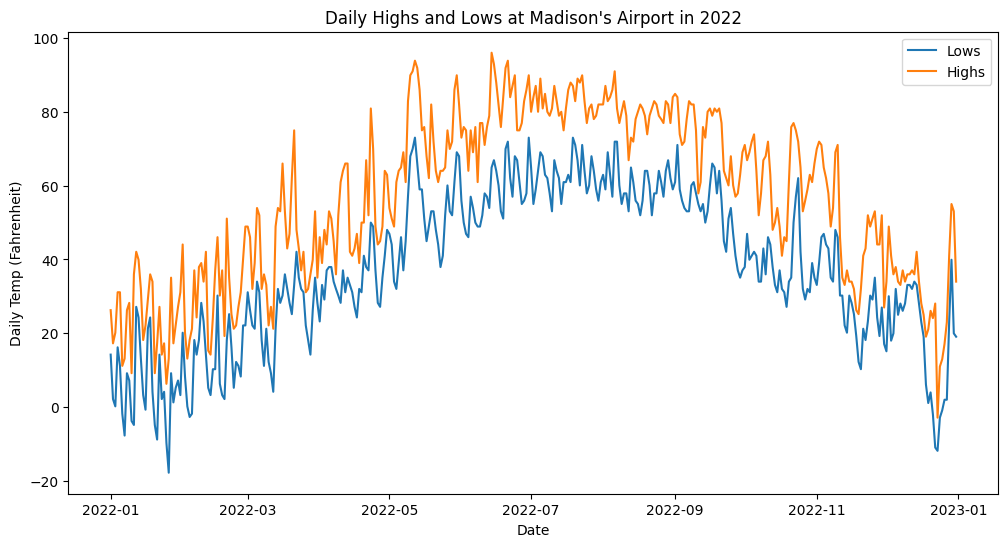

In [13]:
import matplotlib.pyplot as plt

madison = spark.sql("""
SELECT date,
       to_fahrenheit(record.tmin) as tmin_fahrenheit,
       to_fahrenheit(record.tmax) as tmax_fahrenheit
FROM weather2022
WHERE id = 'USW00014837'
ORDER BY date
""")

madison_pd = madison.toPandas()


plt.figure(figsize=(12, 6))
plt.plot(madison_pd["date"], madison_pd["tmin_fahrenheit"], label="Lows")
plt.plot(madison_pd["date"], madison_pd["tmax_fahrenheit"], label="Highs")
plt.xlabel("Date")
plt.ylabel("Daily Temp (Fahrenheit)")
plt.title("Daily Highs and Lows at Madison's Airport in 2022")
plt.legend()
plt.show()

### Q4: what is the correlation between maximum temperatures in Madison and Milwaukee?


In [14]:
from pyspark.sql.functions import corr

madison_max_temps = weather2022.filter(weather2022["id"] == "USW00014837").select("date", "record.tmax")
milwaukee_max_temps = weather2022.filter(weather2022["id"] == "USW00014839").select("date", "record.tmax")

madison_max_temps = madison_max_temps.withColumnRenamed("tmax", "mad_tmax")
milwaukee_max_temps = milwaukee_max_temps.withColumnRenamed("tmax", "mil_tmax")
combined_max_temps = madison_max_temps.join(milwaukee_max_temps, on="date")

correlation = combined_max_temps.select(corr("mad_tmax", "mil_tmax").alias("correlation")).collect()[0]["correlation"]

print(f"Correlation: {correlation}")


Correlation: 0.9786907979650685


# Part 4: Disaster Strikes

In [15]:
import warnings
warnings.filterwarnings("ignore")

### Q5: does StationMax still work?


In [16]:
stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))
# Yes

tmax: 356

### Q6: does simulate_sensor still work?


In [17]:
simulate_sensor("USC00477115")
# Yes

max temp for USC00477115 is 333


### Q7: Q7: how does refreshing the stale cache change the number of rows in weather2022?


In [18]:
print(f"BEFORE REFRESH: {weather2022.count()}")
spark.catalog.refreshTable("weather2022")

weather2022 = spark.table("weather2022")
print(f"AFTER REFRESH: {weather2022.count()}")

# It increases the number or rows by 365

BEFORE REFRESH: 1460


AFTER REFRESH: 1825
